# AdaBoost

revision: 78571a2

In [1]:
# @formatter:off
# PREAMBLE

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from mlis.arrays import asinput, aslabel
%matplotlib inline
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")
%load_ext autoreload
%autoreload 2
# @formatter:on

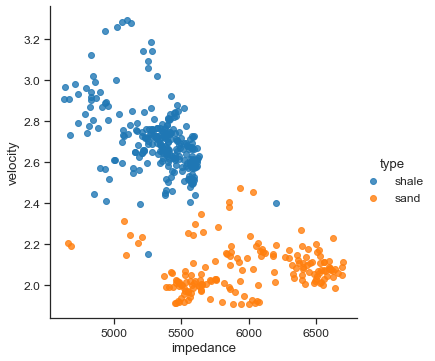

In [2]:
# load rock types data set
# there is no need to normalize the data when using decision trees
df = pd.read_csv('rocktypes.csv', sep=' ')
df['label'] = df['type'].apply(lambda string: -1 if string == 'sand' else +1)
sns.lmplot(x='impedance', y='velocity', hue='type', data=df, fit_reg=False)


# Plotting decision regions
def plot_desicion_boundary(X, y, clf):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    x_enlarge = (x_max - x_min) * 0.1
    y_enlarge = (y_max - y_min) * 0.1
    xx, yy = np.meshgrid(np.linspace(x_min - x_enlarge, x_max + x_enlarge, 300),
                         np.linspace(y_min - y_enlarge, y_max + y_enlarge, 300))
    XX = np.c_[xx.ravel(), yy.ravel()]
    Z = clf(XX).reshape(xx.shape)
    cmap = sns.diverging_palette(275, 10, as_cmap=True)
    plt.contourf(xx, yy, Z, alpha=.2, cmap=cmap, levels=np.linspace(Z.min(), Z.max(), 20))
    plt.contour(xx, yy, Z, levels=[0.0])

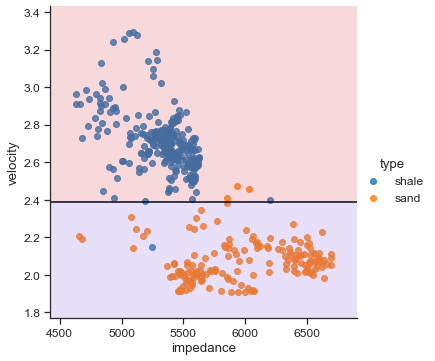

In [3]:
# we will not implement a decision tree regressor again, but use the one from sklearn
from sklearn.tree import DecisionTreeClassifier


# fits a decision tree stump
def stump_fit(X, y, w=None):
    h = DecisionTreeClassifier(max_depth=1)
    h.fit(X, y, sample_weight=w)
    predict = lambda t: h.predict(t)
    return predict


# load data
X = asinput(df[['impedance', 'velocity']])
y = aslabel(df['label'])

# fit a decision tree regressor
stump = stump_fit(X, y)

# plot results
sns.lmplot(x='impedance', y='velocity', hue='type', data=df, fit_reg=False)
plot_desicion_boundary(X, y, stump)

Implement the AdaBoost algorithm as described in the lecture notes.
Plot the decision boundary for $T \in \{10, 50, 100, 1000 \}$.

for T=10 ada_boost classifies 7 training samples incorrectly
for T=50 ada_boost classifies 0 training samples incorrectly
for T=100 ada_boost classifies 0 training samples incorrectly
for T=1000 ada_boost classifies 0 training samples incorrectly


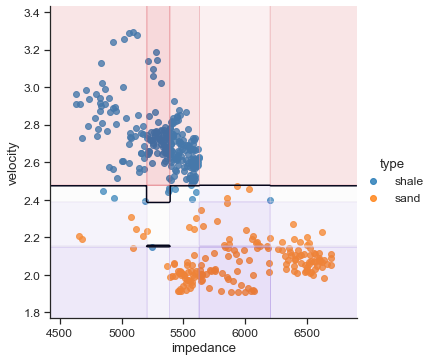

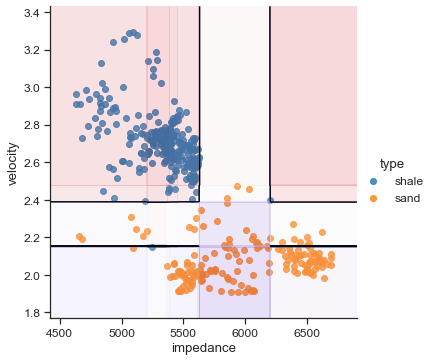

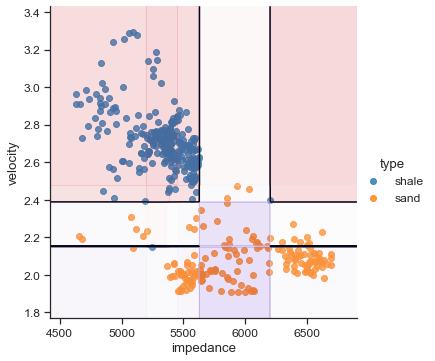

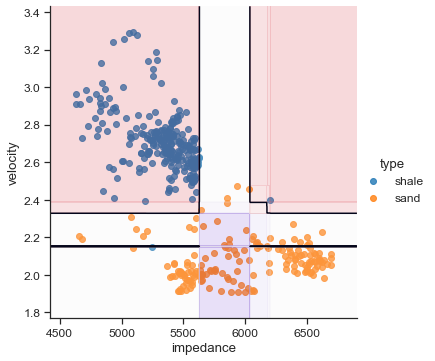

In [67]:
def ada_boost(X, y, T):
    m, n = X.shape

    h_functions = []
    H = lambda X: np.zeros(m)

    w = np.ones(m) / m
    for t in range(T):
        h = stump_fit(X, y, w=w)
        epsilon = np.sum((h(X) != y) * w)
        if epsilon >= 0.5:
            break
        eta = 0.5 * np.log((1 - epsilon) / epsilon)
        w *= np.exp(-y * eta * h(X))
        w /= sum(w)
        h_functions.append(h)
        H = lambda X: np.mean([h(X) for h in h_functions], axis=0)
    return H


for T in [10, 50, 100, 1000]:
    model = ada_boost(X, y, T)
    num_misclassifications = np.count_nonzero(~(np.sign(model(X)) == y))
    print(f"for T={T} ada_boost classifies {num_misclassifications} training samples incorrectly")

    sns.lmplot(x="impedance", y="velocity", hue="type", data=df, fit_reg=False)
    plot_desicion_boundary(X, y, model)
